<a href="https://colab.research.google.com/github/abksyed/EVA4/blob/master/S5/EVA4_S5_Assignment_iter01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Statements

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Targets

**Overall Target to Acheive**
 

1.   99.4% (this must be consistently shown in your last few epochs, and not a one-time achievement)
2.   Less than or equal to 15 Epochs
3.   Less than 10000 Parameters

*Target for this Iteration:*


1.   Build the Basic Model
2.   Import Data and Transform
3.   Set up Training and Testing methods

#Raw Data Statistics

In [2]:
#Getting to know Data
data = datasets.MNIST('./data', train= True, transform= transforms.Compose([transforms.ToTensor(),]), download= True)

exp = data.data
exp = data.transform(exp.numpy())

print('Train Statistics')
print(' - Numpy Shape:', data.data.cpu().numpy().shape)
print(' - Tensor Shape:', data.data.size())
print(' - min:', torch.min(exp))
print(' - max:', torch.max(exp))
print(' - mean:', torch.mean(exp))
print(' - std:', torch.std(exp))
print(' - var:', torch.var(exp))

Train Statistics
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1305)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


#Transforming Raw Data to Normalized Data

In [0]:
#Transforming Data (Normalizing to mean=1, std= 0)
train_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1311,), (0.3081,))
]
)

test_transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.1311,),(0.3081,))
])

#Creating Train/Test Split

In [0]:
#Getting Train and Test Data
train = datasets.MNIST('./data', train= True, transform= train_transform)
test = datasets.MNIST('./data', train= False, transform= test_transform)

#Dataloader Arguments & Test/Train Dataloaders

In [5]:
seed = 1

#CUDA Availability
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

#For Reproducibility
torch.manual_seed(seed)

if cuda:
    torch.cuda.manual_seed(seed)

dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory= True) if cuda else dict(shuffle= True, batch_size=64)

#Train Dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

#Test Dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: torch.Size([28, 60000, 28])
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4255)
 - max: tensor(2.8202)
 - mean: tensor(0.0004)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


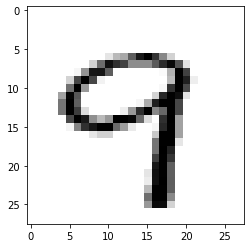

In [6]:
#Testing Normalized Data Statistics

train_numpy = train.train_data
train_numpy = train.transform(train_numpy.numpy())

print('[Train]')
print(' - Numpy Shape:', train_numpy.shape)
print(' - Tensor Shape:', train.data.size())
print(' - min:', torch.min(train_numpy))
print(' - max:', torch.max(train_numpy))
print(' - mean:', torch.mean(train_numpy))
print(' - std:', torch.std(train_numpy))
print(' - var:', torch.var(train_numpy))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

#Viewing Sample Images in Dataset

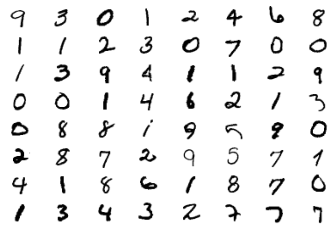

In [7]:
figure = plt.figure()
num_of_images = 64
for index in range(0, num_of_images):
    plt.subplot(8, 8, index+1)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

#**THE MODEL**

In [0]:
class Net(nn.Module):

  def __init__(self):

    super(Net, self).__init__()

    #Input Block - Input= 28
    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels= 1, out_channels= 8, kernel_size= 3, padding= 1, bias= False),
        nn.ReLU()
    ) #Output= 28 / ReceptiveField= 3

    #Convolution Block - Input= 28
    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels= 8, out_channels= 8, kernel_size= 3, padding= 1, bias= False),
        nn.ReLU()
    ) #Output= 28 / ReceptiveField= 5

    #Max Pooling and 1x1 Convolution
    self.mp1 = nn.Sequential(
        nn.MaxPool2d(2),
        #nn.Conv2d(in_channels= 16, out_channels= 8, kernel_size= 1, bias= False)
    )#Output= 14 / ReceptiveField= 6

    #Convolution Block - Input= 14
    self.block3 = nn.Sequential(
        nn.Conv2d(in_channels= 8, out_channels= 16, kernel_size= 3, padding= 1, bias= False),
        nn.ReLU(), 
        #Output= 14 / ReceptiveField= 10
        nn.Conv2d(in_channels= 16, out_channels= 16, kernel_size= 3, padding= 1, bias= False),
        nn.ReLU()
    ) #Output= 14 / ReceptiveField= 14

    #Max Pooling and 1x1 Convolution
    self.mp2 = nn.Sequential(
        nn.MaxPool2d(2),
        nn.Conv2d(in_channels= 16, out_channels= 8, kernel_size= 1, bias= False)
    )#Output= 7 / ReceptiveField= 16    

    #Convolution Block - Input= 7
    self.block4 = nn.Sequential(
        nn.Conv2d(in_channels= 8, out_channels= 20, kernel_size= 3, padding= 0, bias= False),
        nn.ReLU(), 
        #Output= 5 / ReceptiveField= 24
        nn.Conv2d(in_channels= 20, out_channels= 10, kernel_size= 3, padding= 0, bias= False),
    ) #Output= 3 / ReceptiveField= 32

    #GAP - Input 3
    self.gap = nn.AvgPool2d(3)
    #Output= 1 / ReceptiveField= 32

  def forward(self,x):

     x = self.block1(x)
     x = self.block2(x)
     x = self.mp1(x)
     x = self.block3(x)
     x = self.mp2(x)
     x = self.block4(x)
     x = self.gap(x)
     x = x.view(-1,10)

     return F.log_softmax(x, dim=-1)

#Inspecting Model Parameters

In [9]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
            Conv2d-3            [-1, 8, 28, 28]             576
              ReLU-4            [-1, 8, 28, 28]               0
         MaxPool2d-5            [-1, 8, 14, 14]               0
            Conv2d-6           [-1, 16, 14, 14]           1,152
              ReLU-7           [-1, 16, 14, 14]               0
            Conv2d-8           [-1, 16, 14, 14]           2,304
              ReLU-9           [-1, 16, 14, 14]               0
        MaxPool2d-10             [-1, 16, 7, 7]               0
           Conv2d-11              [-1, 8, 7, 7]             128
           Conv2d-12             [-1, 20, 5, 5]           1,440
             ReLU-13             [-1, 20, 5, 5]               0
           Conv2d-14             [

#Training and Testing

In [0]:
from tqdm import tqdm

train_loss = []
test_loss = []

train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()

    y_pred = model(data)

    loss = F.nll_loss(y_pred, target)
    train_loss.append(loss)

    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim= True)
    correct+= pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100 * correct/processed)

In [0]:
def test(model, device, test_loader):
  model.eval()
  correct= 0
  tloss= 0

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)

      output = model(data)

      tloss+= F.nll_loss(output, target, reduction= 'sum').item()
      pred= output.argmax(dim= 1, keepdim= True)
      correct+= pred.eq(target.view_as(pred)).sum().item()

  tloss /= len(test_loader.dataset)
  test_loss.append(tloss)
  print(100 * correct/len(test_loader.dataset))
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        tloss, correct, len(test_loader.dataset),
        100 * correct/len(test_loader.dataset)))
  
  test_acc.append(100 * correct/len(test_loader.dataset))

#Running the Model

In [12]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr= 0.01, momentum= 0.9)
epochs = 15

for epoch in range(epochs):
  print('EPOCH: ', epoch+1)
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH:  1


Loss=0.15958081185817719 Batch_id=937 Accuracy=43.64: 100%|██████████| 938/938 [00:11<00:00, 81.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

94.08

Test set: Average loss: 0.1868, Accuracy: 9408/10000 (94.08%)

EPOCH:  2


Loss=0.005657672882080078 Batch_id=937 Accuracy=96.19: 100%|██████████| 938/938 [00:11<00:00, 83.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

97.33

Test set: Average loss: 0.0824, Accuracy: 9733/10000 (97.33%)

EPOCH:  3


Loss=0.07659898698329926 Batch_id=937 Accuracy=97.63: 100%|██████████| 938/938 [00:11<00:00, 84.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

98.16

Test set: Average loss: 0.0585, Accuracy: 9816/10000 (98.16%)

EPOCH:  4


Loss=0.03358817100524902 Batch_id=937 Accuracy=98.17: 100%|██████████| 938/938 [00:11<00:00, 81.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

98.48

Test set: Average loss: 0.0442, Accuracy: 9848/10000 (98.48%)

EPOCH:  5


Loss=0.0014408528804779053 Batch_id=937 Accuracy=98.41: 100%|██████████| 938/938 [00:11<00:00, 82.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

98.58

Test set: Average loss: 0.0431, Accuracy: 9858/10000 (98.58%)

EPOCH:  6


Loss=0.019868209958076477 Batch_id=937 Accuracy=98.58: 100%|██████████| 938/938 [00:11<00:00, 82.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

98.62

Test set: Average loss: 0.0436, Accuracy: 9862/10000 (98.62%)

EPOCH:  7


Loss=0.25858116149902344 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:11<00:00, 82.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

98.83

Test set: Average loss: 0.0376, Accuracy: 9883/10000 (98.83%)

EPOCH:  8


Loss=0.0036626458168029785 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [00:11<00:00, 82.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

98.79

Test set: Average loss: 0.0371, Accuracy: 9879/10000 (98.79%)

EPOCH:  9


Loss=0.03000086545944214 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [00:11<00:00, 83.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

98.63

Test set: Average loss: 0.0431, Accuracy: 9863/10000 (98.63%)

EPOCH:  10


Loss=0.0019145011901855469 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:11<00:00, 82.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.04

Test set: Average loss: 0.0307, Accuracy: 9904/10000 (99.04%)

EPOCH:  11


Loss=0.00034689903259277344 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:11<00:00, 83.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

98.75

Test set: Average loss: 0.0389, Accuracy: 9875/10000 (98.75%)

EPOCH:  12


Loss=0.022784270346164703 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [00:11<00:00, 82.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

98.87

Test set: Average loss: 0.0355, Accuracy: 9887/10000 (98.87%)

EPOCH:  13


Loss=0.03019624948501587 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [00:11<00:00, 82.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.09

Test set: Average loss: 0.0296, Accuracy: 9909/10000 (99.09%)

EPOCH:  14


Loss=0.016775667667388916 Batch_id=937 Accuracy=99.23: 100%|██████████| 938/938 [00:11<00:00, 82.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

98.87

Test set: Average loss: 0.0344, Accuracy: 9887/10000 (98.87%)

EPOCH:  15


Loss=0.05024613440036774 Batch_id=937 Accuracy=99.23: 100%|██████████| 938/938 [00:11<00:00, 82.98it/s]


99.1

Test set: Average loss: 0.0263, Accuracy: 9910/10000 (99.10%)




Max Training Loss 2.3107829093933105 with Max Training Accuracy 100.0

Max Testing Loss 0.18678639733791352 with Max Testing Accuracy 99.1


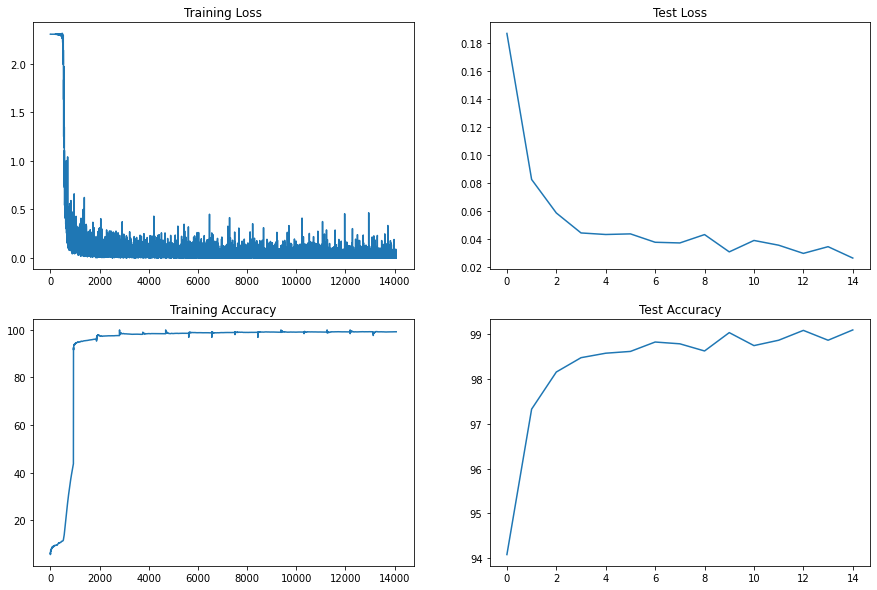

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_loss)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

print()
print(f'Max Training Loss {max(train_loss)} with Max Training Accuracy {max(train_acc)}')
print()
print(f'Max Testing Loss {max(test_loss)} with Max Testing Accuracy {max(test_acc)}')

#Results



1.   Parameters Used: **7474**
1.   Test Accuracy: **99.1%**
2.   Training Accuracy: **100%**
2.   Epochs Used: **15**



#Analysis



1.   Clear Over-fitting of model, as Train accuracy has reached 100% and can't be increase futher, so no more scope for increase in Test Accuracy
2.   Number of Parameters used are nearly 7500, so more 2500 parameters can be used if required.
3.   Need to reduce to Overfitting




